# Workshop 7 - Performance Evaluation

In this workshop we're going to take two models, and compare and present them as if we're pitching to stakeholders.

In this case we'll compare a gradient boosting model and a random forest model, using the full procedure including nested CV. This time around we'll be using the Presence/Absence gene features in the interest of time as the models train much faster

Lets run through the steps together (there are some questions and some blanks to fill in as we run through).

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sklearn
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from tensorflow import keras
import bayes_opt

2024-06-02 16:04:33.985219: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Load Data


For this workshop please download the latest:
- `train_test_data` folder and put within `data/`

Key for data:
- train_pa_genes = presence absence binary features for training data
- test_pa_genes = presence absence binary features for test data
- y_train = array of S/R target values
- y_train_ids = array of genome_ids in order of y_train
- y_test_ids = array of genome_ids in order of y_test

In [2]:
seed = 130

def load_data():
    """
    Load the data needed for Workshop 5
    """
    # Load PA data
    train_pa_genes = pd.read_csv('../data/train_test_data/train_pa_genes.csv').set_index('genome_id')
    test_pa_genes = pd.read_csv('../data/train_test_data/test_pa_genes.csv').set_index('genome_id')
    
    # Load target data & IDs
    y_train = np.load('../data/train_test_data/y_train.npy', allow_pickle=True)
    y_train_ids = np.load('../data/train_test_data/train_ids.npy', allow_pickle=True).astype(str)
    y_test_ids = np.load('../data/train_test_data/test_ids.npy', allow_pickle=True).astype(str)
    
    return train_pa_genes, test_pa_genes, y_train, y_train_ids, y_test_ids

X_train_pa, X_test_pa, y_train, y_train_ids, y_test_ids = load_data()
X_train, X_test = np.array(X_train_pa), np.array(X_test_pa)
y_train = y_train.reshape(-1) # convert to vector

## 2. Use Nested CV to Optimize & Estimate Model Performance

Before we review and analyze we need to train a few models used nested CV

Nested CV will allow us to both hyperparameter tune on the inner fold & get an unbiased estimate of performance on the outer fold

**Notes:**

We're doing 5 outer CV folds for model assessment, training 2 models and for each of those doing 10 random parameter searches on the inner 5 fold CV.

All in all this means we're training: 5x10x2x5 = 500 individual models!

No wonder we don't want to do this for training neural networks. As mentioned this nested CV approach is the full package for giving both a fair assessment of model fit and finding the best parameters, it will not always be viable/possible depending on time/cost constraints.

In this case we're using the presence/absence features where the data size is small and the models train in fractions of a second. For the kmer models this process could take hours!

In [3]:
# First build a manual K-fold loop using K=5
K = 5
kfold = sklearn.model_selection.KFold(
    n_splits = K,
    shuffle = True, # Want to shuffle as seen in slides
    random_state = seed, # To ensure reproducible results
)

rf_fold_perf = {}
gb_fold_perf = {}

# Loop through each of our 5 outer folds once at a time
for i, (train_index, val_index) in enumerate(kfold.split(X_train)):

    print(f"Starting Outer fold {i}")
    X_train_outer, X_val_outer, y_train_outer, y_val_outer  = (
        X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
    )

    # RANDOM FOREST MODEL FIT AND EVALUATE
    print("Optimizing RFC")
    rfc_random_cv = sklearn.model_selection.RandomizedSearchCV(
        estimator = ensemble.RandomForestClassifier(random_state = seed),
        param_distributions = {
            "n_estimators" : stats.randint(low=1, high=20),
            "max_depth": stats.randint(low=1, high=10),
        },
        n_iter = 10, # Sample 4 times from distribution
        cv = 5, # Use 2 fold CV (for speed, in reality we'd want to set to some higher number 5/10 etc.)
        scoring = sklearn.metrics.make_scorer(sklearn.metrics.balanced_accuracy_score) # Use balanced accuracy to score
    )
    
    # Fit the model
    rfc_random_cv.fit(X_train_outer, y_train_outer)  # Here we're using just the train_outer from our manual K-fold split

    # Assess the best model using the outer validation data
    y_pred_outer_rfc = rfc_random_cv.predict(X_val_outer)
    rf_fold_perf[i] = sklearn.metrics.confusion_matrix(y_val_outer, y_pred_outer_rfc, labels=["S","R"])
    
    # GRADIENT BOOSTING MODEL FIT AND EVALUATE
    print("Optimizing GBC")
    gbc_random_cv = sklearn.model_selection.RandomizedSearchCV(
        estimator = ensemble.AdaBoostClassifier(
            estimator = tree.DecisionTreeClassifier(max_depth=1),
            algorithm="SAMME",
        ),
        param_distributions = {
            "n_estimators" : stats.randint(low=1, high=20),
            "learning_rate": stats.loguniform(0.001, 1),
        },
        n_iter = 10, # Sample 4 times from distribution
        cv = 5, # Use 2 fold CV (for speed, in reality we'd want to set to some higher number 5/10 etc.)
        scoring = sklearn.metrics.make_scorer(sklearn.metrics.balanced_accuracy_score) # Use balanced accuracy to score
    )

    # Fit the model
    gbc_random_cv.fit(X_train_outer, y_train_outer)  # Here we're using just the train_outer from our manual K-fold split

    # Assess the best model using the outer validation data
    y_pred_outer_gbc = gbc_random_cv.predict(X_val_outer)
    gb_fold_perf[i] = sklearn.metrics.confusion_matrix(y_val_outer, y_pred_outer_gbc, labels=["S","R"])
    print("\n")

Starting Outer fold 0
Optimizing RFC
Optimizing GBC


Starting Outer fold 1
Optimizing RFC
Optimizing GBC


Starting Outer fold 2
Optimizing RFC
Optimizing GBC


Starting Outer fold 3
Optimizing RFC
Optimizing GBC


Starting Outer fold 4
Optimizing RFC
Optimizing GBC




## 3. Review the Model outputs

At this point we've saved out the confusion matrices for both models on each of our outer folds
- The inner fold information is hidden from us at this point (we didn't store it)
- This isn't important though, we just need to know that the best model we could find was chosen
- We're using the outer folds for our unbiased performance assessment

What do we want to present?
- Confusion matrices
- Sensitivity/Specificity
- Balanced accuracy
- Mean and Variance across folds

In [4]:
# Take a look at what we kept from the random forest model
rf_fold_perf

{0: array([[114,   6],
        [ 17,  13]]),
 1: array([[112,   6],
        [ 12,  20]]),
 2: array([[115,   9],
        [  6,  20]]),
 3: array([[111,   4],
        [ 19,  15]]),
 4: array([[114,   7],
        [ 14,  14]])}

In [5]:
# Combine all the data across folds into a single matrix
combined_matrix = np.mean(list(rf_fold_perf.values()), axis=0)
pd.DataFrame(data = combined_matrix, index=["S", "R"], columns=["S","R"])

,S,R
S,113.2,6.4
R,13.6,16.4


#### Calculate Metrics:

First we can simplify and find the mean of all our metrics (using the mean of the confusion matrices)

In [6]:
def calculate_metrics(confusion_matrix):
    # Accuracy = correct / total
    accuracy = (confusion_matrix[0,0] + confusion_matrix[1,1]) / confusion_matrix.sum()
    
    # Sensitivity = Fraction of positive class predicted correctly
    sensitivity = confusion_matrix[1,1] / confusion_matrix[1,:].sum()
    
    # Specificity = Fraction of negative class predicted correctly
    specificity = confusion_matrix[0,0] / confusion_matrix[0,:].sum()
    
    # Balanced accuracy = average of sensitivity and specificity
    balanced_accuracy = np.mean([sensitivity, specificity])

    return accuracy, sensitivity, specificity, balanced_accuracy

In [7]:
accuracy_rf, sensitivity_rf, specificity_rf, balanced_accuracy_rf = calculate_metrics(combined_matrix)

print(f"Accuracy: {np.round(accuracy_rf, 2)}")
print(f"Sensitivity: {np.round(sensitivity_rf, 2)}")
print(f"Specificity: {np.round(specificity_rf, 2)}")
print(f"Balanced Accuracy: {np.round(balanced_accuracy_rf, 2)}")

Accuracy: 0.87
Sensitivity: 0.55
Specificity: 0.95
Balanced Accuracy: 0.75


#### Lets check for our other model

In [8]:
accuracy_gb, sensitivity_gb, specificity_gb, balanced_accuracy_gb = calculate_metrics(
    np.mean(list(gb_fold_perf.values()), axis=0)
)

print(f"Accuracy: {np.round(accuracy_gb, 2)}")
print(f"Sensitivity: {np.round(sensitivity_gb, 2)}")
print(f"Specificity: {np.round(specificity_gb, 2)}")
print(f"Balanced Accuracy: {np.round(balanced_accuracy_gb, 2)}")

Accuracy: 0.88
Sensitivity: 0.71
Specificity: 0.92
Balanced Accuracy: 0.81


<div class="question" style="color: #534646; background-color: #ffdfa3; padding: 1px; border-radius: 5px;">

#### Q. Do we know which model is better?

</div>

## 4. Across Fold Variability

How much do the individual models vary across folds?

Importantly - if we train this model again do we expect to get close to the performance we see above?

Instead of combining matrices and calculating metrics, lets calculation the variability across each metric
- We can use confidence intervals!

In [9]:
def calculate_normal_confidence_intervals(confusion_matrices_list):

    acc_list = []
    sens_list = []
    spec_list = []
    ba_list = []
    for confusion_matrix in confusion_matrices_list:
        # Accuracy = correct / total
        acc_list.append((confusion_matrix[0,0] + confusion_matrix[1,1]) / confusion_matrix.sum())
        sens_list.append(confusion_matrix[1,1] / confusion_matrix[1,:].sum())
        spec_list.append(confusion_matrix[0,0] / confusion_matrix[0,:].sum())
        ba_list.append(np.mean([confusion_matrix[1,1] / confusion_matrix[1,:].sum(), 
                                confusion_matrix[0,0] / confusion_matrix[0,:].sum()]))

    loc, std = np.mean(acc_list), np.std(acc_list)
    accuracy_ci = stats.norm.interval(0.95, loc=loc, scale=std)

    loc, std = np.mean(sens_list), np.std(sens_list)
    sensitivity_ci = stats.norm.interval(0.95, loc=loc, scale=std)

    loc, std = np.mean(spec_list), np.std(spec_list)
    specificity_ci = stats.norm.interval(0.95, loc=loc, scale=std)

    loc, std = np.mean(ba_list), np.std(ba_list)
    balanced_accuracy_ci = stats.norm.interval(0.95, loc=loc, scale=std)
    
    return accuracy_ci, sensitivity_ci, specificity_ci, balanced_accuracy_ci

In [10]:
# For Random Forest Model
acc_ci_rf, sens_ci_rf, spec_ci_rf, ba_ci_rf = calculate_normal_confidence_intervals(list(rf_fold_perf.values()))

# For Gradient Boosted Model
acc_ci_gb, sens_ci_gb, spec_ci_gb, ba_ci_gb = calculate_normal_confidence_intervals(list(gb_fold_perf.values()))

In [11]:
ba_ci_rf

(0.6344072789475247, 0.8661284454522463)

In [12]:
ba_ci_gb

(0.6764105213155255, 0.952672463537927)

#### If we had more time we could also check how confident we should be in individual statistic based on sample size

## 5. Present Results

Given our two models - how can we easily summarize and present this information?

- Lets make a quick plot

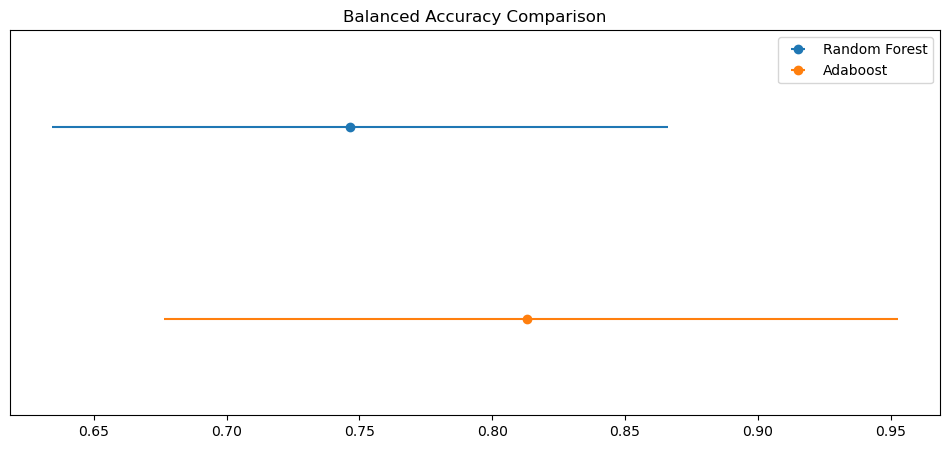

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))

xerr = np.array((balanced_accuracy_rf - ba_ci_rf[0], ba_ci_rf[1] - balanced_accuracy_rf)).reshape(2,1)
ax.errorbar(y=1, x=balanced_accuracy_rf, xerr=xerr, fmt='o', label = "Random Forest")

xerr = np.array((balanced_accuracy_gb - ba_ci_gb[0], ba_ci_gb[1] - balanced_accuracy_gb)).reshape(2,1)
ax.errorbar(y=0, x=balanced_accuracy_gb, xerr=xerr, fmt='o', label = "Adaboost")
ax.set_yticks([])
ax.set_title("Balanced Accuracy Comparison")
ax.set_ylim(-0.5, 1.5)
ax.legend();

<div class="question" style="color: #534646; background-color: #ffdfa3; padding: 1px; border-radius: 5px;">

#### Q. Now what do we think?

</div>

## 6. Train a Final Model

Now we have a very strong idea of how we expect out final model to perform, we can now ignore the evaluation portion.

Our final assessment will be predictions on the final test dataset (Kaggle competition dataset).

So now we want to use a single CV fold to train our final model on all the data.
- For the above assessment to be valid we need to use the same modeling procedure
- We can think about our "model" as the full fitting process

In [14]:
# Use the same CV process to find out final model but across all the training data
gbc_final_cv = sklearn.model_selection.RandomizedSearchCV(
    estimator = ensemble.AdaBoostClassifier(
        estimator = tree.DecisionTreeClassifier(max_depth=1),
        algorithm="SAMME",
    ),
    param_distributions = {
        "n_estimators" : stats.randint(low=1, high=20),
        "learning_rate": stats.loguniform(0.001, 1),
    },
    n_iter = 10, # Sample 4 times from distribution
    cv = 5, # Use 2 fold CV (for speed, in reality we'd want to set to some higher number 5/10 etc.)
    scoring = sklearn.metrics.make_scorer(sklearn.metrics.balanced_accuracy_score) # Use balanced accuracy to score
)

# Fit the model
gbc_final_cv.fit(X_train, y_train)  # Here we're using just the train_outer from our manual K-fold split

RandomizedSearchCV(cv=5,
                   estimator=AdaBoostClassifier(algorithm='SAMME',
                                                estimator=DecisionTreeClassifier(max_depth=1)),
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x158af5210>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x158ab0160>},
                   scoring=make_scorer(balanced_accuracy_score, response_method='predict'))

In [15]:
# Find our optimal parameters and train a single model:
final_lr = gbc_final_cv.best_estimator_.get_params()["learning_rate"]
final_n_est = gbc_final_cv.best_estimator_.get_params()["n_estimators"]

In [16]:
final_lr, final_n_est

(0.0628097176548187, 17)

In [17]:
# Fit final model
final_model = ensemble.AdaBoostClassifier(
    estimator = tree.DecisionTreeClassifier(max_depth=1),
    algorithm="SAMME",
    learning_rate = final_lr, 
    n_estimators = final_n_est,
)
final_model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.0628097176548187, n_estimators=17)

In [18]:
y_pred_test = final_model.predict(X_test)

In [19]:
final_predictions = pd.DataFrame(data = {"genome_id":y_test_ids, "y_pred":y_pred_test})

In [20]:
final_predictions

,genome_id,y_pred
0,562.42833,S
1,562.42739,R
2,562.22823,S
3,562.45646,S
4,562.22547,S
...,...,...
195,562.7666,S
196,562.28389,S
197,562.65798,R
198,562.45645,R


### And we're done!

- We have our final model which we can use to make predictions
- The test submissions can be submitted as our final single assessment of the model
- In order to understand how well we expect the model to perform, we have the Nested CV results
- The model is clearly highly variable
- We might expect to reasonably see anywhere from 68% - 98% balanced accuracy!
- Even if this particular model does well we don't expect this to be a great model overall

Next steps would be to write this up, check how well the model performs individually on sensitivity and specificity and iterate!
- Can we solve our high variability problem?
- Is the model unstable
- Is our data too variable?
- We didn't use sample weighting - maybe the model is struggling on the minority class?
- Or maybe we need to stratify our splits to ensure even balance of S to R
- Always need to iterate!